<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#General-Information" data-toc-modified-id="General-Information-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>General Information</a></span></li><li><span><a href="#Imports" data-toc-modified-id="Imports-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Imports</a></span></li><li><span><a href="#Experiment-environment-/-system-metrics" data-toc-modified-id="Experiment-environment-/-system-metrics-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Experiment environment / system metrics</a></span></li><li><span><a href="#Notebook-options" data-toc-modified-id="Notebook-options-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Notebook options</a></span></li><li><span><a href="#Source" data-toc-modified-id="Source-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Source</a></span><ul class="toc-item"><li><span><a href="#Train-/-Valid-/-Test-lists" data-toc-modified-id="Train-/-Valid-/-Test-lists-5.1"><span class="toc-item-num">5.1&nbsp;&nbsp;</span>Train / Valid / Test lists</a></span></li></ul></li><li><span><a href="#DataSets-config" data-toc-modified-id="DataSets-config-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>DataSets config</a></span></li><li><span><a href="#Datasets" data-toc-modified-id="Datasets-7"><span class="toc-item-num">7&nbsp;&nbsp;</span>Datasets</a></span></li><li><span><a href="#Transforms" data-toc-modified-id="Transforms-8"><span class="toc-item-num">8&nbsp;&nbsp;</span>Transforms</a></span><ul class="toc-item"><li><span><a href="#Define-Label-remaping" data-toc-modified-id="Define-Label-remaping-8.1"><span class="toc-item-num">8.1&nbsp;&nbsp;</span>Define Label remaping</a></span></li><li><span><a href="#Define-transforms" data-toc-modified-id="Define-transforms-8.2"><span class="toc-item-num">8.2&nbsp;&nbsp;</span>Define transforms</a></span></li><li><span><a href="#Apply-transforms" data-toc-modified-id="Apply-transforms-8.3"><span class="toc-item-num">8.3&nbsp;&nbsp;</span>Apply transforms</a></span></li><li><span><a href="#Points-per-voxel-distribution" data-toc-modified-id="Points-per-voxel-distribution-8.4"><span class="toc-item-num">8.4&nbsp;&nbsp;</span>Points per voxel distribution</a></span></li></ul></li><li><span><a href="#DataBunch" data-toc-modified-id="DataBunch-9"><span class="toc-item-num">9&nbsp;&nbsp;</span>DataBunch</a></span><ul class="toc-item"><li><span><a href="#Dataloader-idle-run-speed-measurement" data-toc-modified-id="Dataloader-idle-run-speed-measurement-9.1"><span class="toc-item-num">9.1&nbsp;&nbsp;</span>Dataloader idle run speed measurement</a></span></li></ul></li><li><span><a href="#Model" data-toc-modified-id="Model-10"><span class="toc-item-num">10&nbsp;&nbsp;</span>Model</a></span><ul class="toc-item"><li><span><a href="#learner-creation" data-toc-modified-id="learner-creation-10.1"><span class="toc-item-num">10.1&nbsp;&nbsp;</span>learner creation</a></span></li><li><span><a href="#Learning-Rate-finder" data-toc-modified-id="Learning-Rate-finder-10.2"><span class="toc-item-num">10.2&nbsp;&nbsp;</span>Learning Rate finder</a></span></li></ul></li><li><span><a href="#Train" data-toc-modified-id="Train-11"><span class="toc-item-num">11&nbsp;&nbsp;</span>Train</a></span></li><li><span><a href="#Results" data-toc-modified-id="Results-12"><span class="toc-item-num">12&nbsp;&nbsp;</span>Results</a></span></li><li><span><a href="#Save" data-toc-modified-id="Save-13"><span class="toc-item-num">13&nbsp;&nbsp;</span>Save</a></span></li><li><span><a href="#Validate" data-toc-modified-id="Validate-14"><span class="toc-item-num">14&nbsp;&nbsp;</span>Validate</a></span><ul class="toc-item"><li><span><a href="#Load-weights" data-toc-modified-id="Load-weights-14.1"><span class="toc-item-num">14.1&nbsp;&nbsp;</span>Load weights</a></span></li><li><span><a href="#Validate" data-toc-modified-id="Validate-14.2"><span class="toc-item-num">14.2&nbsp;&nbsp;</span>Validate</a></span></li></ul></li></ul></div>

# General Information

This notebook demonstrates how the `fastai_sparse` library can be used in semantic segmentation tasks using the example of the [ScanNet](http://www.scan-net.org/) 3D semantic segmentation solution presented in [SparseConvNet example](https://github.com/facebookresearch/SparseConvNet/tree/master/examples/ScanNet). 


<img src="http://www.scan-net.org/img/scannet_benchmark.jpg" width="800" />

Initial data are indoor scenes with RGB and 3D-geometric information obtained as a result of three-dimensional scanning (100...500K vertices in ~1500 internal scenes). Format: 3D geometry mesh in format PLY.
The purpose - to predict a label of each vertices (20 furniture classes).

Evaluation metric: IoU (intersection over union)

Firstly, it is necessary to upload and prepare the initial data.  See [examples/scannet/data](https://github.com/goodok/fastai_sparse/tree/master/examples/scannet/data)


In [1]:
import os
#os.environ['CUDA_VISIBLE_DEVICES'] = '0'

In [2]:
#import torch
#print(torch.cuda.is_available())

# Imports

In [3]:
import os, sys
import time
import math
import datetime
import numpy as np
import pandas as pd
import glob
from os.path import join, exists, basename, splitext
from pathlib import Path
from matplotlib import pyplot as plt
from matplotlib import cm
import shutil
from functools import partial
from tqdm import tqdm
from joblib import Parallel, delayed, cpu_count
from IPython.display import display, HTML, FileLink

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

import sparseconvnet as scn

from fastai_sparse import utils, visualize
from fastai_sparse.utils import log, log_dict, print_random_states
from fastai_sparse.data import SparseDataBunch
from fastai_sparse.datasets import DataSourceConfig, PointsDataset#, reader_fn
from fastai_sparse.learner import SparseModelConfig, Learner
from fastai_sparse.callbacks import TimeLogger, SaveModelCallback, CSVLogger, CSVLoggerIouByCategory
from fastai_sparse.metrics import IouMean
from metrics import IouMeanFiltred
from callbacks import CSVLoggerIouByClass
from data import merge_fn
import transforms as T
# autoreload python modules on the fly when its source is changed
%load_ext autoreload
%autoreload 2
from fastai.callbacks.general_sched import TrainingPhase, GeneralScheduler

from fastai.callback import annealing_exp
from data import merge_fn

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


Importing modules specific to this task (standard 3D semantic markers, ScanNet)

# Experiment environment / system metrics

# Notebook options

In [4]:
experiment_name = 'scannet_unet_detailed'
utils.wide_notebook()
# uncomment this lines if you want switch off interactive and save visaulisation as screenshoots:
# For rendering run command in terminal:    `chromium-browser --remote-debugging-port=9222`
if  True:
    visualize.options.interactive = False
    visualize.options.save_images = True
    visualize.options.verbose = True
    visualize.options.filename_pattern_image = Path('images', experiment_name, 'fig_{fig_number}')

# Source

In [5]:
SOURCE_DIR = Path('train_val_lists')
definition_of_spliting_dir = Path('train_val_lists')

## Train / Valid / Test lists

MeshesDataset uses the pandas DataFrame as a datasource to determine the splitting into testing/valid as well as files locations.

In [6]:
def get_df_list(verbose=0):
    # train /valid / test splits
    fn_lists = {}

    fn_lists['train'] = definition_of_spliting_dir / 'train.txt'
    fn_lists['valid'] = definition_of_spliting_dir / 'valid.txt'
    fn_lists['test'] = definition_of_spliting_dir / 'test.txt'

    for datatype in ['train', 'valid', 'test']:
        assert fn_lists[datatype].exists(), datatype

    dfs = {}
    total = 0
    for datatype in ['train', 'valid', 'test']:
        df = pd.read_csv(fn_lists[datatype], header=None, names=['example_id'])
        df = df.assign(datatype=datatype)
        df = df.assign(subdir=df.example_id)
        df = df.sort_values('example_id')
        dfs[datatype] = df

        if verbose:
            print(f"{datatype:5} counts: {len(df):>4}")
        
        total += len(df)
    if verbose:
        print(f"total:     {total}")
    return dfs

In [7]:
df_list = get_df_list(verbose=1)
df_list['train']

train counts:   16
valid counts:    4
test  counts:    3
total:     23


example_id datatype            subdir
0   Lille1_1-Cloud-1    train  Lille1_1-Cloud-1
1   Lille1_1-Cloud-2    train  Lille1_1-Cloud-2
2   Lille1_1-Cloud-3    train  Lille1_1-Cloud-3
3   Lille1_1-Cloud-4    train  Lille1_1-Cloud-4
4   Lille1_2-Cloud-1    train  Lille1_2-Cloud-1
5   Lille1_2-Cloud-2    train  Lille1_2-Cloud-2
6   Lille1_2-Cloud-3    train  Lille1_2-Cloud-3
7   Lille1_2-Cloud-4    train  Lille1_2-Cloud-4
8     Lille2-Cloud-1    train    Lille2-Cloud-1
9     Lille2-Cloud-2    train    Lille2-Cloud-2
10    Lille2-Cloud-3    train    Lille2-Cloud-3
11    Lille2-Cloud-4    train    Lille2-Cloud-4
12     Paris-Cloud-1    train     Paris-Cloud-1
13     Paris-Cloud-2    train     Paris-Cloud-2
14     Paris-Cloud-3    train     Paris-Cloud-3
15     Paris-Cloud-4    train     Paris-Cloud-4

# DataSets config
You can create MeshDataset using the configuration.

In [55]:
train_source_config = DataSourceConfig(root_dir=SOURCE_DIR,
                                       df=df_list['train'],
                                       batch_size=2,
                                       num_workers=0,
                                       ply_label_name='scalar_class',
                                       file_ext='.ply',
                                      )
train_source_config

DataSourceConfig;
   root_dir: train_val_lists
   batch_size: 2
   num_workers: 0
   file_ext: .ply
   ply_label_name: scalar_class
   init_numpy_random_seed: True
 Items count: 16

In [56]:
valid_source_config = DataSourceConfig(root_dir=SOURCE_DIR,
                                       df=df_list['valid'],
                                       batch_size=1,
                                       num_workers=0,
                                       ply_label_name='scalar_class',
                                       file_ext='.ply',
                                       #init_numpy_random_seed=False,
                                      )
valid_source_config

DataSourceConfig;
   root_dir: train_val_lists
   batch_size: 1
   num_workers: 0
   file_ext: .ply
   ply_label_name: scalar_class
   init_numpy_random_seed: True
 Items count: 4

# Datasets

In [99]:
train_items = PointsDataset.from_source_config(train_source_config)
valid_items = PointsDataset.from_source_config(valid_source_config)

train_items.check()
valid_items.check()

Check files exist: 100%|██████████| 4/4 [00:00<00:00, 7622.54it/s]


Let's see what we've done with one example. 

In interactive mode, you can switch the color parameters (labels, rgb) to display labels or scan colors.

In [100]:
o = train_items[0]
o.describe()
#o.show()

PointsItem (Lille1_1-Cloud-1)
points                   shape: (5335668, 3)          dtype: float64        min: -412.13937,  max:   59.54536,  mean: -211.04363
labels                   shape: (5335668,)            dtype: float64        min:    0.00000,  max:    9.00000,  mean:    2.43979
intensity                shape: (5335668,)            dtype: float64        min:    0.00000,  max:  255.00000,  mean:   19.95988


In [12]:
# short representation
train_items[0]

PointsItem ('Lille1_1-Cloud-1', n: 5335668)

# Transforms

## Define Label remaping

In [101]:
df_classes = pd.read_csv(definition_of_spliting_dir / 'classes.txt', header=None, names=['class_id', 'name'], delim_whitespace=True)
df_classes.T

0       1         2     3        4      5        6  \
class_id             0       1         2     3        4      5        6   
name      unclassified  ground  building  pole  bollard  trash  barrier   

                   7    8           9  
class_id           7    8           9  
name      pedestrian  car  vegetation

## Define transforms

In order to reproduce the [example of SparseConvNet](https://github.com/facebookresearch/SparseConvNet/tree/master/examples/ScanNet), the same transformations have been redone, but in the manner of fast.ai transformations.

The following cells define the transformations: preprocessing (PRE_TFMS); augmentation (AUGS_); and transformation to convert the points cloud to a sparse representation (SPARSE_TFMS). Sparse  representation is the input format for the SparseConvNet model and contains a list of voxels and their features

In [102]:
SPARSE_TFMS = [
    T.merge_features(ones=False, intensity=True),
    T.to_sparse_voxels(),
]

# train/valid transforms
tfms = (
    SPARSE_TFMS,
)

## Apply transforms
Now we will apply the transformation to the data sets.

In [103]:
train_items.transform(tfms[0])
pass

valid_items.transform(tfms[0])
pass

Let's see what we got in results of train and valid tranformations for the first example:

##### Train

In [104]:
o = train_items[0]
o.describe()
#o.show(colors=o.data['features'])

id: Lille1_1-Cloud-1
coords                   shape: (5335668, 3)          dtype: int64          min:       -413,  max:         59,  mean: -211.54351
features                 shape: (5335668,)            dtype: float64        min:    0.00000,  max:  255.00000,  mean:   19.95988
x                        shape: (5335668,)            dtype: int64          min:       -361,  max:       -254,  mean: -308.03011
y                        shape: (5335668,)            dtype: int64          min:       -413,  max:       -329,  mean: -368.32403
z                        shape: (5335668,)            dtype: int64          min:         32,  max:         59,  mean:   41.72362
labels                   shape: (5335668,)            dtype: float32        min:    0.00000,  max:    9.00000,  mean:    2.43979
voxels: 11759
points / voxels: 453.7518496470788


##### Valid

In [120]:
o = valid_items[0]
o.describe()

id: Lille1_1-Cloud-5
coords                   shape: (8066818, 3)          dtype: int64          min:        -50,  max:        101,  mean:   29.03096
features                 shape: (8066818,)            dtype: float64        min:    0.00000,  max:  255.00000,  mean:   20.37722
x                        shape: (8066818,)            dtype: int64          min:        -44,  max:         67,  mean:   12.73459
y                        shape: (8066818,)            dtype: int64          min:        -50,  max:        101,  mean:   26.63084
z                        shape: (8066818,)            dtype: int64          min:         40,  max:         64,  mean:   47.72745
labels                   shape: (8066818,)            dtype: float32        min:    0.00000,  max:    9.00000,  mean:    2.56039
voxels: 15882
points / voxels: 507.9220501196323


## Points per voxel distribution 

In [18]:
# iterations are in one thread
ppv_valid = []
for o in tqdm(valid_items, total=len(valid_items)):
    n_voxels = o.num_voxels()
    n_points = len(o.data['coords'])
    ppv_valid.append(n_points / n_voxels)

ppv_train = []
for o in tqdm(train_items, total=len(train_items)):
    n_voxels = o.num_voxels()
    n_points = len(o.data['coords'])
    ppv_train.append(n_points / n_voxels)


  0%|          | 0/4 [00:00<?, ?it/s]

KeyboardInterrupt: 

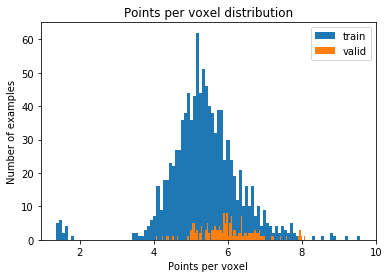

In [27]:
fig, ax = plt.subplots()
ax.hist(ppv_train, bins=100, label='train')
ax.hist(ppv_valid, bins=100, label='valid')
ax.legend()
ax.set_title('Points per voxel distribution')
ax.set_xlabel('Points per voxel')
ax.set_ylabel('Number of examples')
pass

# DataBunch

In fast.ai the data is represented DataBunch which contains train, valid and optionally test data loaders.

In [105]:
#o = train_items[0]
#p=o.data['coords']
#i=0
#for idx, x in enumerate(p): 
#                    if i<10:
#                        print(x.shape[0])
#                        i=i+1
#a = [np.hstack([x, idx * np.ones((x.shape[0]), dtype='int64')])
#                for idx, x in enumerate(p)]
data = SparseDataBunch.create(train_ds=train_items,
                              valid_ds=valid_items,
                              collate_fn=merge_fn)


2


In [ ]:
data

In [92]:
data.describe()

Train:    16, shuffle:  True, batch_size:  2, num_workers:  0, num_batches: 8, drop_last: True
Valid:     4, shuffle: False, batch_size:  1, num_workers:  0, num_batches: 4, drop_last: False


## Dataloader idle run speed measurement

# Model
U-Net SparseConvNet implemenation ([link](https://github.com/facebookresearch/SparseConvNet/blob/master/examples/ScanNet/unet.py)): 

In [131]:
# spatial_size  is full_scale
#assert torch.cuda.is_available()
model_config = SparseModelConfig(spatial_size=4096, num_classes=10, num_input_features=1, mode=2,
                                 m=16, num_planes_coeffs=[1, 2, 3, 4, 5])
model_config

SparseModelConfig;
   spatial_size: 4096
   dimension: 3
   block_reps: 1
   m: 16
   num_planes: [16, 32, 48, 64, 80]
   residual_blocks: False
   num_classes: 10
   num_input_features: 1
   mode: 2
   downsample: [2, 2]
   bias: False

In [132]:
class Model(nn.Module):
    def __init__(self, cfg):
        nn.Module.__init__(self)
        self.sparseModel = scn.Sequential(
            scn.InputLayer(cfg.dimension, cfg.spatial_size, mode=cfg.mode),
            scn.SubmanifoldConvolution(cfg.dimension, nIn=cfg.num_input_features, nOut=cfg.m, filter_size=3, bias=cfg.bias),
            scn.UNet(cfg.dimension, cfg.block_reps, cfg.num_planes, residual_blocks=cfg.residual_blocks, downsample=cfg.downsample),
            scn.BatchNormReLU(cfg.m),
            scn.OutputLayer(cfg.dimension),
        )
        self.linear = nn.Linear(cfg.m, cfg.num_classes)

    def forward(self, xb):
        #a=xb['coords'], b = xb['features']
        x = [xb['coords'], xb['features']]
        x = self.sparseModel(x)
        x = self.linear(x)
        return x

model = Model(model_config)
#device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
#model.to(device)

In [133]:
utils.print_trainable_parameters(model)

Total: 961,242


name              shape  \
0                               sparseModel.1.weight    27 x 1 x 1 x 16   
1                           sparseModel.2.0.0.weight                 16   
2                             sparseModel.2.0.0.bias                 16   
3                           sparseModel.2.0.1.weight   27 x 1 x 16 x 16   
4                         sparseModel.2.1.1.0.weight                 16   
5                           sparseModel.2.1.1.0.bias                 16   
6                         sparseModel.2.1.1.1.weight    8 x 1 x 16 x 32   
7                     sparseModel.2.1.1.2.0.0.weight                 32   
8                       sparseModel.2.1.1.2.0.0.bias                 32   
9                     sparseModel.2.1.1.2.0.1.weight   27 x 1 x 32 x 32   
10                  sparseModel.2.1.1.2.1.1.0.weight                 32   
11                    sparseModel.2.1.1.2.1.1.0.bias                 32   
12                  sparseModel.2.1.1.2.1.1.1.weight    8 x 1 x 32 x 48   
13              sparseModel.2.1.1.2.1.1.2.0.0.weight                 48   
14                sparseModel.2.1.1.2.1.1.2.0.0.bias                 48   
15              sparseModel.2.1.1.2.1.1.2.0.1.weight   27 x 1 x 48 x 48   
16            sparseModel.2.1.1.2.1.1.2.1.1.0.weight                 48   
17              sparseModel.2.1.1.2.1.1.2.1.1.0.bias                 48   
18            sparseModel.2.1.1.2.1.1.2.1.1.1.weight    8 x 1 x 48 x 64   
19        sparseModel.2.1.1.2.1.1.2.1.1.2.0.0.weight                 64   
20          sparseModel.2.1.1.2.1.1.2.1.1.2.0.0.bias                 64   
21        sparseModel.2.1.1.2.1.1.2.1.1.2.0.1.weight   27 x 1 x 64 x 64   
22      sparseModel.2.1.1.2.1.1.2.1.1.2.1.1.0.weight                 64   
23        sparseModel.2.1.1.2.1.1.2.1.1.2.1.1.0.bias                 64   
24      sparseModel.2.1.1.2.1.1.2.1.1.2.1.1.1.weight    8 x 1 x 64 x 80   
25  sparseModel.2.1.1.2.1.1.2.1.1.2.1.1.2.0.0.weight                 80   
26    sparseModel.2.1.1.2.1.1.2.1.1.2.1.1.2.0.0.bias                 80   
27  sparseModel.2.1.1.2.1.1.2.1.1.2.1.1.2.0.1.weight   27 x 1 x 80 x 80   
28      sparseModel.2.1.1.2.1.1.2.1.1.2.1.1.3.weight                 80   
29        sparseModel.2.1.1.2.1.1.2.1.1.2.1.1.3.bias                 80   
30      sparseModel.2.1.1.2.1.1.2.1.1.2.1.1.4.weight    8 x 1 x 80 x 64   
31        sparseModel.2.1.1.2.1.1.2.1.1.2.3.0.weight                128   
32          sparseModel.2.1.1.2.1.1.2.1.1.2.3.0.bias                128   
33        sparseModel.2.1.1.2.1.1.2.1.1.2.3.1.weight  27 x 1 x 128 x 64   
34            sparseModel.2.1.1.2.1.1.2.1.1.3.weight                 64   
35              sparseModel.2.1.1.2.1.1.2.1.1.3.bias                 64   
36            sparseModel.2.1.1.2.1.1.2.1.1.4.weight    8 x 1 x 64 x 48   
37              sparseModel.2.1.1.2.1.1.2.3.0.weight                 96   
38                sparseModel.2.1.1.2.1.1.2.3.0.bias                 96   
39              sparseModel.2.1.1.2.1.1.2.3.1.weight   27 x 1 x 96 x 48   
40                  sparseModel.2.1.1.2.1.1.3.weight                 48   
41                    sparseModel.2.1.1.2.1.1.3.bias                 48   
42                  sparseModel.2.1.1.2.1.1.4.weight    8 x 1 x 48 x 32   
43                    sparseModel.2.1.1.2.3.0.weight                 64   
44                      sparseModel.2.1.1.2.3.0.bias                 64   
45                    sparseModel.2.1.1.2.3.1.weight   27 x 1 x 64 x 32   
46                        sparseModel.2.1.1.3.weight                 32   
47                          sparseModel.2.1.1.3.bias                 32   
48                        sparseModel.2.1.1.4.weight    8 x 1 x 32 x 16   
49                          sparseModel.2.3.0.weight                 32   
50                            sparseModel.2.3.0.bias                 32   
51                          sparseModel.2.3.1.weight   27 x 1 x 32 x 16   
52                              sparseModel.3.weight                 16  

## learner creation
Learner is core fast.ai class which contains model architecture, databunch and optimizer options and implement train loop and prediction

In [134]:
learn = Learner(data, model,
                opt_func=partial(optim.Adam),
                path=str(Path('results', experiment_name)))
#learn.model.cuda()

## Learning Rate finder
We use Learning Rate Finder provided by fast.ai library to find the optimal learning rate

In [135]:
learn.lr_find()

2
LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


RuntimeError: Dimension out of range (expected to be in range of [-1, 0], but got 1) (maybe_wrap_dim at /pytorch/c10/core/WrapDimMinimal.h:20)
frame #0: c10::Error::Error(c10::SourceLocation, std::string const&) + 0x33 (0x7f083289a193 in /usr/local/lib/python3.6/site-packages/torch/lib/libc10.so)
frame #1: <unknown function> + 0xee5acc (0x7f08339a5acc in /usr/local/lib/python3.6/site-packages/torch/lib/libtorch.so)
frame #2: at::native::size(at::Tensor const&, long) + 0x20 (0x7f08339a5d80 in /usr/local/lib/python3.6/site-packages/torch/lib/libtorch.so)
frame #3: std::result_of<c10::Dispatcher::callUnboxed<long, at::Tensor const&, long>(c10::OperatorHandle const&, at::Tensor const&, long) const::{lambda(c10::DispatchTable const&)#1} (c10::DispatchTable const&)>::type c10::LeftRight<c10::DispatchTable>::read<c10::Dispatcher::callUnboxed<long, at::Tensor const&, long>(c10::OperatorHandle const&, at::Tensor const&, long) const::{lambda(c10::DispatchTable const&)#1}>(c10::Dispatcher::callUnboxed<long, at::Tensor const&, long>(c10::OperatorHandle const&, at::Tensor const&, long) const::{lambda(c10::DispatchTable const&)#1}&&) const + 0x134 (0x7f0831d63684 in /floyd/home/SparseConvNet/sparseconvnet/SCN.cpython-36m-x86_64-linux-gnu.so)
frame #4: <unknown function> + 0x98f62 (0x7f0831d39f62 in /floyd/home/SparseConvNet/sparseconvnet/SCN.cpython-36m-x86_64-linux-gnu.so)
frame #5: void InputLayer_updateOutput<3>(Metadata<3>&, at::Tensor&, at::Tensor&, at::Tensor&, at::Tensor&, long, long) + 0x42 (0x7f0831dad062 in /floyd/home/SparseConvNet/sparseconvnet/SCN.cpython-36m-x86_64-linux-gnu.so)
frame #6: <unknown function> + 0x8c11c (0x7f0831d2d11c in /floyd/home/SparseConvNet/sparseconvnet/SCN.cpython-36m-x86_64-linux-gnu.so)
frame #7: <unknown function> + 0x81d7a (0x7f0831d22d7a in /floyd/home/SparseConvNet/sparseconvnet/SCN.cpython-36m-x86_64-linux-gnu.so)
<omitting python frames>
frame #15: THPFunction_apply(_object*, _object*) + 0xa8f (0x7f0841e503bf in /usr/local/lib/python3.6/site-packages/torch/lib/libtorch_python.so)


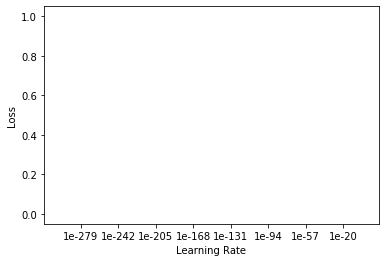

In [136]:
learn.recorder.plot()

# Train
To visualize the learning process, we specify some additional callbacks 

In [137]:
learn.callbacks = []
cb_iouf = IouMeanFiltred(learn, model_config.num_classes)
learn.callbacks.append(cb_iouf)
learn.callbacks.append(TimeLogger(learn))

learn.callbacks.append(CSVLogger(learn))
learn.callbacks.append(CSVLoggerIouByClass(learn, cb_iouf, class_names=list(df_classes.name), filename='iouf_by_class'))
learn.callbacks.append(SaveModelCallback(learn, every='epoch', name='weights', overwrite=True))

In [138]:
learn.fit(10)

2


RuntimeError: Dimension out of range (expected to be in range of [-1, 0], but got 1) (maybe_wrap_dim at /pytorch/c10/core/WrapDimMinimal.h:20)
frame #0: c10::Error::Error(c10::SourceLocation, std::string const&) + 0x33 (0x7f083289a193 in /usr/local/lib/python3.6/site-packages/torch/lib/libc10.so)
frame #1: <unknown function> + 0xee5acc (0x7f08339a5acc in /usr/local/lib/python3.6/site-packages/torch/lib/libtorch.so)
frame #2: at::native::size(at::Tensor const&, long) + 0x20 (0x7f08339a5d80 in /usr/local/lib/python3.6/site-packages/torch/lib/libtorch.so)
frame #3: std::result_of<c10::Dispatcher::callUnboxed<long, at::Tensor const&, long>(c10::OperatorHandle const&, at::Tensor const&, long) const::{lambda(c10::DispatchTable const&)#1} (c10::DispatchTable const&)>::type c10::LeftRight<c10::DispatchTable>::read<c10::Dispatcher::callUnboxed<long, at::Tensor const&, long>(c10::OperatorHandle const&, at::Tensor const&, long) const::{lambda(c10::DispatchTable const&)#1}>(c10::Dispatcher::callUnboxed<long, at::Tensor const&, long>(c10::OperatorHandle const&, at::Tensor const&, long) const::{lambda(c10::DispatchTable const&)#1}&&) const + 0x134 (0x7f0831d63684 in /floyd/home/SparseConvNet/sparseconvnet/SCN.cpython-36m-x86_64-linux-gnu.so)
frame #4: <unknown function> + 0x98f62 (0x7f0831d39f62 in /floyd/home/SparseConvNet/sparseconvnet/SCN.cpython-36m-x86_64-linux-gnu.so)
frame #5: void InputLayer_updateOutput<3>(Metadata<3>&, at::Tensor&, at::Tensor&, at::Tensor&, at::Tensor&, long, long) + 0x42 (0x7f0831dad062 in /floyd/home/SparseConvNet/sparseconvnet/SCN.cpython-36m-x86_64-linux-gnu.so)
frame #6: <unknown function> + 0x8c11c (0x7f0831d2d11c in /floyd/home/SparseConvNet/sparseconvnet/SCN.cpython-36m-x86_64-linux-gnu.so)
frame #7: <unknown function> + 0x81d7a (0x7f0831d22d7a in /floyd/home/SparseConvNet/sparseconvnet/SCN.cpython-36m-x86_64-linux-gnu.so)
<omitting python frames>
frame #15: THPFunction_apply(_object*, _object*) + 0xa8f (0x7f0841e503bf in /usr/local/lib/python3.6/site-packages/torch/lib/libtorch_python.so)


It takes 512 epochs to get IoU ~ 0.44 by this simple model.

In [ ]:
learn.fit(512)

# Results

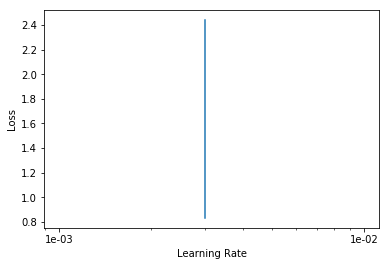

In [39]:
learn.recorder.plot()

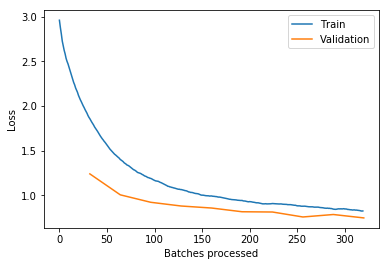

In [40]:
learn.recorder.plot_losses()

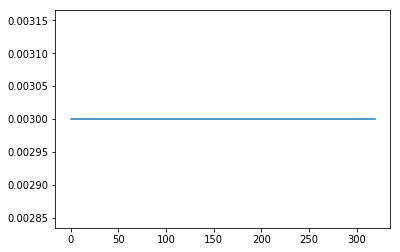

In [41]:
learn.recorder.plot_lr()

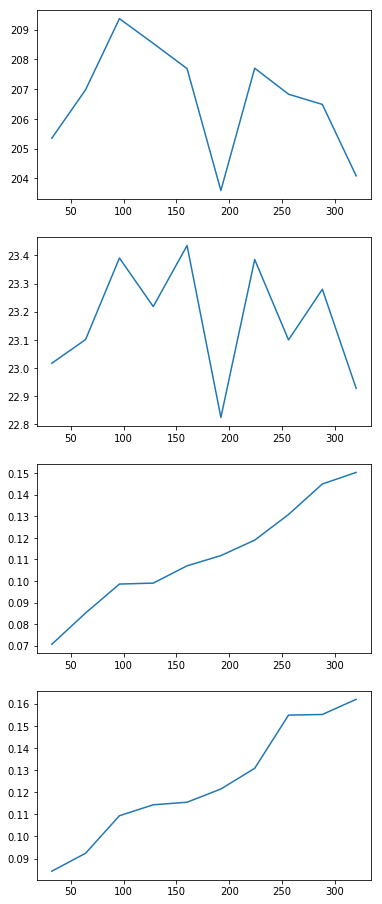

In [42]:
learn.recorder.plot_metrics()

In [43]:
cb = learn.find_callback(CSVLoggerIouByClass)
cb.read_logged_file().iloc[-1:].T

19
epoch                  9
datatype           valid
mean_iou        0.162001
wall            0.782948
floor           0.424996
cabinet         0.938655
bed             0.378823
chair                  0
sofa            0.193514
table           0.000129
door            0.219227
window          0.001197
bookshelf              0
picture          0.30053
counter                0
desk                   0
curtain                0
refridgerator          0
shower                 0
toilet                 0
sink                   0
bathtub                0
otherfurniture         0

# Save

Save manually

In [44]:
fn_checkpoint = learn.path / learn.model_dir / 'learn_model.pth'
#torch.save(epoch, 'epoch.pth')
torch.save(model.state_dict(), fn_checkpoint)

Check saved weights

In [45]:
model.load_state_dict(torch.load(fn_checkpoint))

# Validate

## Load weights

In [46]:
fn_checkpoint = learn.path / learn.model_dir / 'weights.pth'
print(fn_checkpoint)
assert fn_checkpoint.exists()
assert os.path.isfile(fn_checkpoint)
fn_epoch = learn.path / learn.model_dir / 'weights_epoch.pth'
print("Epoch:", torch.load(fn_epoch))

results/scannet_unet_detailed/models/weights.pth
Epoch: 9


In [47]:
learn.model.load_state_dict(torch.load(fn_checkpoint)['model'])

## Validate

In [48]:
# remove callback, because CSVLogger not worked with `learn.validate`
learn.callbacks = []

cb_iouf = IouMeanFiltred(learn, model_config.num_classes)

validation_callbacks = [cb_iouf, TimeLogger(learn)]

In [49]:
np.random.seed(42)
last_metrics = learn.validate(callbacks=validation_callbacks)
last_metrics

[0.7385204, 0.0, 22.492323875427246, 0, 0.16579058166051072]

Internal validation details

In [50]:
print(repr(cb_iouf._d['valid']['cm']))
cb_iouf._d['valid']['iou']

array([[5219183,   49143,   53814,   27336, ...,    6722,   10765,   15817,    2493],
       [  21218,  313395,    4806,   33068, ...,      70,    3487,    1600,     299],
       [  45583,   14697, 3402678,    4787, ...,       0,    1930,     386,     328],
       [   6379,   34626,    2530,  190044, ...,       0,    2174,     550,     123],
       ...,
       [      0,       0,       0,       0, ...,       0,       0,       0,       0],
       [      0,       0,       0,       0, ...,       0,       0,       0,       0],
       [      0,       0,       0,       0, ...,       0,       0,       0,       0],
       [      0,       0,       0,       0, ...,       0,       0,       0,       0]], dtype=uint64)


0.16579058166051072

In [51]:
cb_iouf._d['valid']['cm']

array([[5219183,   49143,   53814,   27336, ...,    6722,   10765,   15817,    2493],
       [  21218,  313395,    4806,   33068, ...,      70,    3487,    1600,     299],
       [  45583,   14697, 3402678,    4787, ...,       0,    1930,     386,     328],
       [   6379,   34626,    2530,  190044, ...,       0,    2174,     550,     123],
       ...,
       [      0,       0,       0,       0, ...,       0,       0,       0,       0],
       [      0,       0,       0,       0, ...,       0,       0,       0,       0],
       [      0,       0,       0,       0, ...,       0,       0,       0,       0],
       [      0,       0,       0,       0, ...,       0,       0,       0,       0]], dtype=uint64)

In [52]:
cb_iouf._d['valid']['iou_per_class']

array([7.880392e-01, 4.225936e-01, 9.400460e-01, 3.798183e-01, 2.508623e-18, 1.968258e-01, 4.778085e-04, 2.801127e-01,
       8.102176e-04, 9.072681e-18, 3.070880e-01, 1.622007e-17, 2.669728e-17, 8.308270e-18, 3.822776e-17, 9.639483e-17,
       1.401935e-16, 3.400667e-17, 4.517528e-17, 8.165265e-17])

In [53]:
cb_iouf._d['valid']['iou']

0.16579058166051072